Failed to load encoder_features_epoch_24/21.pth: PytorchStreamReader failed reading file data/0: invalid header or archive is corrupted
Failed to load encoder_features_epoch_24/26.pth: PytorchStreamReader failed reading file data/0: invalid header or archive is corrupted
Failed to load encoder_features_epoch_24/50.pth: PytorchStreamReader failed reading file data/0: invalid header or archive is corrupted
Failed to load encoder_features_epoch_24/58.pth: PytorchStreamReader failed reading file data/0: invalid header or archive is corrupted
Failed to load encoder_features_epoch_24/69.pth: PytorchStreamReader failed reading file data/0: invalid header or archive is corrupted
Failed to load encoder_features_epoch_24/79.pth: PytorchStreamReader failed reading file data/0: invalid header or archive is corrupted
Failed to load encoder_features_epoch_24/98.pth: PytorchStreamReader failed reading file data/0: invalid header or archive is corrupted
Failed to load encoder_features_epoch_24/131.pth

ValueError: The 'color' keyword argument must have one color per dataset, but 128 datasets and 1 colors were provided

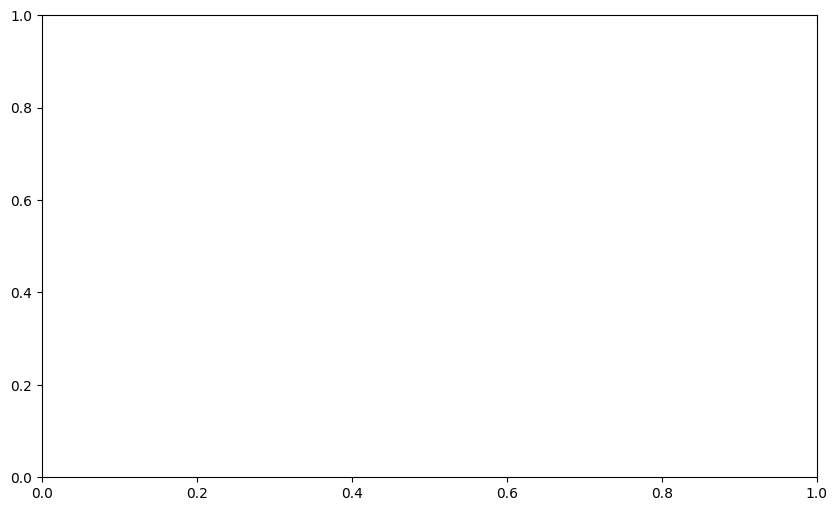

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

class EncoderAnalyzer:
    def __init__(self, dim):
        self.norm = nn.LayerNorm(dim)

    def load_encoder_features(self, folder_path):
        encoder_features = []
        
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.pth'):
                file_path = os.path.join(folder_path, file_name)
                # 加载 .pth 文件
                try:
                    features = torch.load(file_path)
                    encoder_features.append(features)
                except Exception as e:
                    print(f"Failed to load {file_path}: {e}")

        return encoder_features

    def analyze_features(self, features):
        means = []
        stds = []
        
        # 对每个张量进行 LayerNorm 处理并计算均值和方差
        for feature in features:
            encoder_feature = feature.clone().detach().cpu()  # 复制并转移到 CPU
            x = self.norm(encoder_feature)  # 应用 LayerNorm
            
            means.append(x.mean(dim=1).detach().numpy())  # 计算每个样本的均值
            stds.append(x.std(dim=1).detach().numpy())    # 计算每个样本的标准差

        # 将均值和标准差转换为 numpy 数组
        means = np.concatenate(means)
        stds = np.concatenate(stds)

        # 计算总体均值和总体标准差
        overall_mean = means.mean()
        overall_std = stds.mean()
        
        print("Overall Mean of encoder features:", overall_mean)
        print("Overall Standard deviation of encoder features:", overall_std)

        # 绘制总体分布
        plt.figure(figsize=(10, 6))
        plt.hist(means, bins=50, alpha=0.7, label='Means', color='blue')
        plt.hist(stds, bins=50, alpha=0.7, label='Stds', color='orange')
        plt.title('Distribution of Means and Standard Deviations of Encoder Features')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid()
        plt.show()

In [3]:
print(encoder_features[0].shape)

NameError: name 'encoder_features' is not defined